Google Analytics Customer Revenue - https://www.kaggle.com/c/ga-customer-revenue-prediction
1) Two Data sets, train and test
2) Entity embeddings of categorical variables
3) y = TransactionRevenue, for given x=fullVisitorId

Categorical Variables
['channelGrouping', 'device.browser', 'device.deviceCategory', 'geoNetwork.city', 'device.operatingSystem', 
                'trafficSource.medium', 'trafficSource.source',
                'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',  'geoNetwork.subContinent']

Continues Variables
 ['totals.visits', '_visitHour', '_day', '_month', '_weekday']

json columns ['device', 'geoNetwork', 'totals', 'trafficSource']

columns to drop   ['customDimensions','hits', 'visitId', 'totals.sessionQualityDim']

Submission - Root Mean Squared Error (RMSE)
For each fullVisitorId in the test set, you must predict the natural log of their total revenue in PredictedLogRevenue
fullVisitorId,PredictedLogRevenue

In [6]:
from os import path
from fastai.text import *

D:\python\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\python\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
D:\python\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
from fastai.structured import *
from fastai.column_data import *

In [2]:
import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json fi

In [4]:
# json columns
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [7]:
PATH=Path('data/kg-google/')

In [13]:
p=0.07
chunksize=24000

In [16]:
def json_read(filename):
    df = pd.read_csv(PATH/filename,
                     converters={column: json.loads for column in columns},
                     dtype={'fullVisitorId': 'str'},
                      skiprows=lambda i : i> 0 and random.random() > p
#                      nrows=2000
                     )
    
    for column in columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in  column_as_df.columns]
        df = df.drop(column,axis=1).merge(column_as_df,right_index=True,left_index=True)
        
#     print(f'Loaded {os,path.basename(data_frame)}. Shape: {df.shape}')
    return df    


In [153]:
def json_read_test(filename):
    df = pd.read_csv(PATH/filename,
                     converters={column: json.loads for column in columns},
                      dtype={'fullVisitorId': 'str'},
#                       skiprows=lambda i : i> 0 and random.random() > p
#                      nrows=2000
                     )
    
    for column in columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in  column_as_df.columns]
        df = df.drop(column,axis=1).merge(column_as_df,right_index=True,left_index=True)
        
#     print(f'Loaded {os,path.basename(data_frame)}. Shape: {df.shape}')
    return df    


In [149]:
df_train = json_read('train_v2.csv')

In [154]:
df_test = json_read_test('test_v2.csv')

In [155]:
df_test.size

23693751

In [203]:
# df_test_no_dups = df_test.drop_duplicates(['fullVisitorId'])

In [204]:
# df_test_no_dups.size

6523660

In [19]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    print("\n Total of Sales % of Total: ", round((df_train[df_train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(df_train['totals.transactionRevenue']) * 100),4))
    return 

In [ ]:
df_train["totals.transactionRevenue"] = df_train["totals.transactionRevenue"].fillna(1.0).astype(float) #filling NA with zero

In [21]:
#columns to drop
to_drop = ['customDimensions', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 
        'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.screenColors', 'device.screenResolution', 
       'geoNetwork.cityId', 
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
        'totals.bounces',
       'totals.sessionQualityDim', 
       'totals.totalTransactionRevenue', 
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'
          ]

In [156]:
df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)


Handle date

In [157]:
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # setting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [158]:
df_train = date_process(df_train)
# df_train.head(n=2)
df_test = date_process(df_test)

Fill NA values

In [25]:
def FillingNaValues(df):    # fillna numeric feature
    df['totals.pageviews'].fillna(1, inplace=True).astype(int) #filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True).astype(int) #filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True).astype(int)   #filling NA's with 0
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(1.0).astype(float) #filling NA with zero
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    df_train.loc[df_train['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
    df_train['geoNetwork.city'].fillna("NaN", inplace=True)

    return df #return the transformed dataframe

In [26]:
def NumericalColumns(df):    # fillna numeric feature
    df['totals.pageviews'].fillna(1, inplace=True) #filling NA's with 1
    df['totals.newVisits'].fillna(0, inplace=True) #filling NA's with 0
    df['totals.transactions'].fillna(0, inplace=True) #filling NA's with 0
    df['totals.timeOnSite'].fillna(0, inplace=True) #filling NA's with 0
    
#     df['totals.bounces'].fillna(0, inplace=True)   #filling NA's with 0
#     df['trafficSource.isTrueDirect'].fillna(False, inplace=True) # filling boolean with False
#     df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(1.0).astype(float) #filling NA with zero
    df['totals.pageviews'] = df['totals.pageviews'].astype(int) # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int) # setting numerical column as integer
#     df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float) # setting numerical to float
    df['totals.visits'] = df['totals.visits'].astype(int) # seting as int

    return df #return the transformed dataframe

Normailize data

In [27]:
from sklearn import preprocessing

def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df 

In [159]:
df_train = NumericalColumns(df_train)
df_test = NumericalColumns(df_test)


In [ ]:
# df_train['totals.transactionRevenue']
# df_train = Normalizing(df_train)
# df_test = Normalizing(df_test)
# df_train.columns

Missing values

In [ ]:
# def missing_values(data):
#     total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
#     percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
#     df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
#     return 

In [ ]:
# calling the missing values function
# missing_values(df_train) 
# missing_values(df_test) 


In [ ]:
# df_train = Normalizing(df_train)
# df_test = Normalizing(df_test)

In [160]:
df_train.head().T.head(40)

,0,1,2,3,4
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00
fullVisitorId,6960673291025684308,7390444353235629134,7058083259448191057,9592294493127192752,9630953897602496525
visitStartTime,1508190552,1508157285,1508174145,1508197277,1508206555
device.browser,Chrome,Chrome,Chrome,Safari,Chrome
device.operatingSystem,Windows,Chrome OS,Windows,Macintosh,Windows
device.operatingSystemVersion,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
geoNetwork.city,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
geoNetwork.continent,Americas,Europe,Americas,Europe,Americas
geoNetwork.country,Mexico,United Kingdom,Canada,United Kingdom,Peru


In [113]:
df_test.head().T.head(40)

,0,1,2,3,4
channelGrouping,Affiliates,Direct,Referral,Referral,Organic Search
date,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00
fullVisitorId,0459669224143241747,589440789980446309,5299820794845174508,3326540121689239742,8598143869506191067
visitStartTime,1526054953,1526051458,1526087937,1526068491,1526101388
device.browser,Safari (in-app),Edge,Chrome,Chrome,Chrome
device.operatingSystem,iOS,Windows,Linux,Linux,Windows
device.operatingSystemVersion,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
geoNetwork.city,not available in demo dataset,Madrid,Kirkland,Ann Arbor,Bengaluru
geoNetwork.continent,Asia,Europe,Americas,Americas,Asia
geoNetwork.country,Taiwan,Spain,United States,United States,India


In [161]:
cat_vars = ['channelGrouping', 
       'device.browser', 'device.operatingSystem',
       'device.operatingSystemVersion', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.subContinent','_weekday','_day','_month','_year','_visitHour']
contin_vars = ['totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.timeOnSite', 
       'totals.transactions', 'totals.visits']
#  'fullVisitorId',

In [162]:
dep = 'totals.transactionRevenue'
df_train = df_train[cat_vars+contin_vars+[dep, 'date']].copy()

In [163]:
df_test[dep] = 0.0
df_test = df_test[cat_vars+contin_vars+[dep, 'date', 'fullVisitorId']].copy()

In [164]:
for v in cat_vars: df_train[v] = df_train[v].astype('category').cat.as_ordered()

In [165]:
apply_cats(df_test, df_train)

In [166]:
for v in contin_vars:
    df_train[v] = df_train[v].fillna(0).astype('float32')
    df_test[v] = df_test[v].fillna(0).astype('float32')

In [167]:
samp_size = len(df_train)
df_samp = df_train.set_index("date")

In [168]:
df_samp.head(2)

,channelGrouping,device.browser,device.operatingSystem,device.operatingSystemVersion,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.subContinent,_weekday,...,_month,_year,_visitHour,totals.hits,totals.newVisits,totals.pageviews,totals.timeOnSite,totals.transactions,totals.visits,totals.transactionRevenue
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,Organic Search,Chrome,Windows,not available in demo dataset,not available in demo dataset,Americas,Mexico,not available in demo dataset,Central America,0,...,10,2017,17,2.0,1.0,2.0,52.0,0.0,1.0,1.0
2017-10-16,Organic Search,Chrome,Chrome OS,not available in demo dataset,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,Northern Europe,0,...,10,2017,8,2.0,1.0,2.0,54.0,0.0,1.0,1.0


In [169]:
df, y, nas, mapper = proc_df(df_samp, 'totals.transactionRevenue', do_scale=True)
yl = np.log(y)
# yl = y

In [170]:
df_test = df_test.set_index("date")

In [173]:
df_test1, _, nas, mapper = proc_df(df_test, dep, do_scale=True,skip_flds=['fullVisitorId'],mapper=mapper, na_dict=nas)
# 

In [175]:
df_test1.head(2)

,channelGrouping,device.browser,device.operatingSystem,device.operatingSystemVersion,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.subContinent,_weekday,_day,_month,_year,_visitHour,totals.hits,totals.newVisits,totals.pageviews,totals.timeOnSite,totals.transactions,totals.visits
date,,,,,,,,,,,,,,,,,,,,
2018-05-11,5,9,2,1,1,4,86,100,19,5,11,5,3,1,-0.046609,-1.808697,-0.104528,2.374919,-0.102181,0.0
2018-05-11,3,9,7,1,582,3,196,61,13,5,11,5,3,15,-0.046609,-1.808697,-0.104528,-0.210461,-0.102181,0.0


In [126]:
df.head(2)

,channelGrouping,device.browser,device.operatingSystem,device.operatingSystemVersion,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.subContinent,_weekday,_day,_month,_year,_visitHour,totals.hits,totals.newVisits,totals.pageviews,totals.timeOnSite,totals.transactions,totals.visits
date,,,,,,,,,,,,,,,,,,,,
2017-10-16,5,10,15,1,755,5,189,410,14,1,16,10,2,11,-0.268469,0.551854,-0.257484,-0.274164,-0.083213,0.0
2017-10-16,5,10,18,1,416,4,91,373,7,1,16,10,2,7,-0.268469,-1.812073,-0.257484,-0.299023,-0.083213,0.0


In [176]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [ ]:
# val_idx

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [177]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [178]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test1)

In [179]:
cat_sz = [(c, len(df_samp[c].cat.categories)+1) for c in cat_vars]

In [180]:
cat_sz

[('channelGrouping', 9),
 ('device.browser', 37),
 ('device.operatingSystem', 18),
 ('device.operatingSystemVersion', 2),
 ('geoNetwork.city', 736),
 ('geoNetwork.continent', 7),
 ('geoNetwork.country', 204),
 ('geoNetwork.region', 403),
 ('geoNetwork.subContinent', 24),
 ('_weekday', 8),
 ('_day', 32),
 ('_month', 13),
 ('_year', 4),
 ('_visitHour', 25)]

In [181]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [182]:
emb_szs

[(9, 5),
 (37, 19),
 (18, 9),
 (2, 1),
 (736, 50),
 (7, 4),
 (204, 50),
 (403, 50),
 (24, 12),
 (8, 4),
 (32, 16),
 (13, 7),
 (4, 2),
 (25, 13)]

In [183]:
m = md.get_learner(emb_szs,len(df.columns)-len(cat_vars),0.04,1,[1000,500],[0.001,0.01])
# m.summary()

In [184]:
m.model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(37, 19)
    (2): Embedding(18, 9)
    (3): Embedding(2, 1)
    (4): Embedding(736, 50)
    (5): Embedding(7, 4)
    (6): Embedding(204, 50)
    (7): Embedding(403, 50)
    (8): Embedding(24, 12)
    (9): Embedding(8, 4)
    (10): Embedding(32, 16)
    (11): Embedding(13, 7)
    (12): Embedding(4, 2)
    (13): Embedding(25, 13)
  )
  (lins): ModuleList(
    (0): Linear(in_features=248, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True)
)

In [136]:
lr=3e-6
m.lr_find()

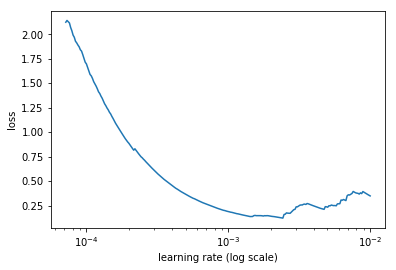

In [137]:
m.sched.plot(100)

In [185]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [186]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      3.278467   3.445321   0.091926  
    1      3.552406   3.445321   0.091917                                                                              
    2      3.029418   3.445321   0.091903                                                                              


[array([3.44532]), 0.09190294244864929]

In [187]:
m.save('model-working2')

In [188]:
m.load('model-working2')

In [189]:
x,y=m.predict_with_targs()

In [190]:
exp_rmspe(x,y)

0.10402312123633399

In [191]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [200]:
df_test.size

8834958

In [205]:
df_test_unique = df_test.fullVisitorId.unique()

In [212]:
pred_test

array([[1.00004],
       [1.00012],
       [1.00005],
       ...,
       [1.00004],
       [1.00003],
       [1.00005]], dtype=float32)

In [209]:
df_test_unique_pd.size

296530

In [213]:
# df_test_unique_pd =  pd.DataFrame(df_test_unique)
df_test[dep]=pred_test-1

In [23]:
csv_fn=f'{PATH}/tmp/sub.csv'

In [214]:
df_test.head(10)

,channelGrouping,device.browser,device.operatingSystem,device.operatingSystemVersion,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,geoNetwork.subContinent,_weekday,...,_year,_visitHour,totals.hits,totals.newVisits,totals.pageviews,totals.timeOnSite,totals.transactions,totals.visits,totals.transactionRevenue,fullVisitorId
date,,,,,,,,,,,,,,,,,,,,,
2018-05-11,Organic Search,Chrome,Android,not available in demo dataset,(not set),Asia,India,Delhi,Southern Asia,4,...,2018,0,4.0,0.0,3.0,973.0,0.0,1.0,0.000037,7460955084541987166
2018-05-11,Direct,Chrome,Macintosh,not available in demo dataset,San Francisco,Americas,United States,California,Northern America,4,...,2018,14,4.0,0.0,3.0,49.0,0.0,1.0,0.000121,460252456180441002
2018-05-11,Organic Search,Chrome,Chrome OS,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,Northern America,4,...,2018,15,4.0,0.0,3.0,24.0,0.0,1.0,0.000052,3461808543879602873
2018-05-11,Direct,Chrome,iOS,not available in demo dataset,Houston,Americas,United States,Texas,Northern America,4,...,2018,2,5.0,0.0,4.0,25.0,0.0,1.0,0.000199,975129477712150630
2018-05-11,Organic Search,Internet Explorer,Windows,not available in demo dataset,Irvine,Americas,United States,California,Northern America,4,...,2018,13,5.0,1.0,4.0,49.0,0.0,1.0,0.000183,8381672768065729990
2018-05-11,Organic Search,Chrome,Windows,not available in demo dataset,not available in demo dataset,Americas,Brazil,not available in demo dataset,South America,4,...,2018,14,5.0,0.0,4.0,120.0,0.0,1.0,0.000098,2866297766347322467
2018-05-11,Direct,Chrome,Android,not available in demo dataset,San Jose,Americas,United States,California,Northern America,4,...,2018,14,5.0,1.0,4.0,58.0,0.0,1.0,0.000129,2235365487897339889
2018-05-11,Organic Search,Chrome,Macintosh,not available in demo dataset,Mountain View,Americas,United States,California,Northern America,4,...,2018,18,5.0,0.0,4.0,56.0,0.0,1.0,0.000077,1303090465617023038
2018-05-11,Affiliates,Safari (in-app),iOS,not available in demo dataset,not available in demo dataset,Asia,Taiwan,not available in demo dataset,Eastern Asia,4,...,2018,12,5.0,1.0,3.0,57.0,0.0,1.0,0.000222,0459669224143241747


In [215]:
df_test.size

8834958

In [199]:
df_test[['fullVisitorId',dep]].to_csv(csv_fn, index=False)

In [28]:
df_try_unique = pd.read_csv(csv_fn,low_memory=False)

In [29]:
df_try_unique = df_try_unique.drop_duplicates(['fullVisitorId'])

In [30]:
df_try_unique.head()


,fullVisitorId,totals.transactionRevenue
0,7460955084541987166,0.000037
1,460252456180441002,0.000121
2,3461808543879602873,0.000052
3,975129477712150630,0.000199
4,8381672768065729990,0.000183


In [32]:
csv_fn1=f'{PATH}/tmp/submission_new.csv'
df_try_unique.to_csv(csv_fn1, index=False)